# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'
data_dir = '/input'
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


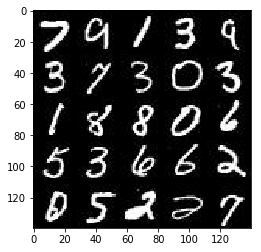

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

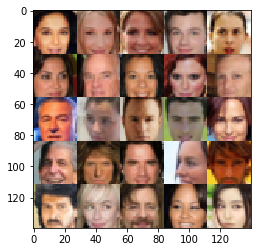

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_data = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name ='input')
    targets = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    keep_probability = tf.placeholder(tf.float32, None, name = 'keep_prob')
    #target_sequence_length = tf.placeholder(tf.int32, (None,), name='target_sequence_length')
    #max_target_sequence_length = tf.reduce_max(target_sequence_length, name='max_target_len')
    #source_sequence_length = tf.placeholder(tf.int32, (None), name='source_sequence_length')
    
    return (input_data, targets, learning_rate)



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
        alpha = 0.2

        #input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # Adding dropout
        relu1 = tf.nn.dropout(relu1, 0.5)
        #14x14x64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # Adding dropout
        relu2 = tf.nn.dropout(relu2, 0.5)
        #7x7x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * x3, x3)
        #7x7x256

        #flatten and pass through fully connected layer to activation funcion
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    #def lrelu(x, leak=0.2, name="lrelu"):
    #    with tf.variable_scope(name):
    #        f1 = 0.5 * (1 + leak)
    #        f2 = 0.5 * (1 - leak)
    #        return f1 * x + f2 * abs(x)
        
    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.2
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # Adding dropout
        x1 = tf.nn.dropout(x1, 0.5)
            # Now for the transpose convolutions..

        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # Adding dropout
        x2 = tf.nn.dropout(x2, 0.5)

        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # Adding dropout
        x3 = tf.nn.dropout(x3, 0.5)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='SAME')
        out = tf.tanh(logits)
    
        return out
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1

    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    #d_loss_real = tf.reduce_mean(
    #    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)* np.random.uniform(0.7, 1.2)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
        
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]

    #Define the model_inputs
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)

    #Define the model_loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)

    #Define the model_opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    #Training metric
    n_total_batches = data_shape[0] // batch_size

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_counter = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_counter +=1
            
                batch_images = batch_images * 2.0
            
                #random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            
                #run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
            
                if batch_counter % 10 ==0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{} - Batch {}/{}: ".format(epoch_i+1, epoch_count, batch_counter, n_total_batches),
                     "Discriminator Loss: {:.4f}".format(train_loss_d),
                     "Generator Loss: {:.4f}".format(train_loss_g))
                if batch_counter % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 - Batch 10/600:  Discriminator Loss: 0.8954 Generator Loss: 1.1112
Epoch 1/2 - Batch 20/600:  Discriminator Loss: 1.3076 Generator Loss: 1.4629
Epoch 1/2 - Batch 30/600:  Discriminator Loss: 0.9943 Generator Loss: 1.4498
Epoch 1/2 - Batch 40/600:  Discriminator Loss: 0.6726 Generator Loss: 3.1700
Epoch 1/2 - Batch 50/600:  Discriminator Loss: 0.9627 Generator Loss: 1.4942
Epoch 1/2 - Batch 60/600:  Discriminator Loss: 1.1401 Generator Loss: 2.2897
Epoch 1/2 - Batch 70/600:  Discriminator Loss: 0.9919 Generator Loss: 1.5693
Epoch 1/2 - Batch 80/600:  Discriminator Loss: 1.0773 Generator Loss: 1.4310
Epoch 1/2 - Batch 90/600:  Discriminator Loss: 1.0012 Generator Loss: 1.7444
Epoch 1/2 - Batch 100/600:  Discriminator Loss: 1.3061 Generator Loss: 0.7704


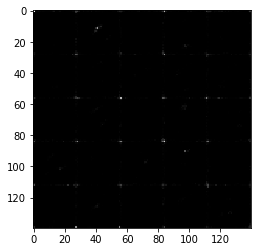

Epoch 1/2 - Batch 110/600:  Discriminator Loss: 0.9957 Generator Loss: 1.3148
Epoch 1/2 - Batch 120/600:  Discriminator Loss: 0.9009 Generator Loss: 1.8046
Epoch 1/2 - Batch 130/600:  Discriminator Loss: 1.1188 Generator Loss: 0.9204
Epoch 1/2 - Batch 140/600:  Discriminator Loss: 1.1549 Generator Loss: 1.7147
Epoch 1/2 - Batch 150/600:  Discriminator Loss: 1.4810 Generator Loss: 0.5783
Epoch 1/2 - Batch 160/600:  Discriminator Loss: 0.8705 Generator Loss: 1.7937
Epoch 1/2 - Batch 170/600:  Discriminator Loss: 0.8840 Generator Loss: 1.5978
Epoch 1/2 - Batch 180/600:  Discriminator Loss: 1.6793 Generator Loss: 0.9533
Epoch 1/2 - Batch 190/600:  Discriminator Loss: 1.3139 Generator Loss: 1.0953
Epoch 1/2 - Batch 200/600:  Discriminator Loss: 1.2583 Generator Loss: 2.7446


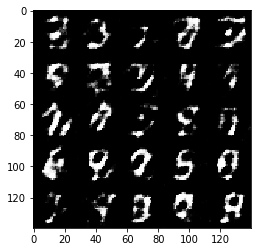

Epoch 1/2 - Batch 210/600:  Discriminator Loss: 0.7775 Generator Loss: 1.5004
Epoch 1/2 - Batch 220/600:  Discriminator Loss: 0.8772 Generator Loss: 1.8726
Epoch 1/2 - Batch 230/600:  Discriminator Loss: 1.3626 Generator Loss: 1.3479
Epoch 1/2 - Batch 240/600:  Discriminator Loss: 0.8838 Generator Loss: 1.6562
Epoch 1/2 - Batch 250/600:  Discriminator Loss: 0.9170 Generator Loss: 1.1770
Epoch 1/2 - Batch 260/600:  Discriminator Loss: 0.9821 Generator Loss: 1.5245
Epoch 1/2 - Batch 270/600:  Discriminator Loss: 1.0751 Generator Loss: 1.3271
Epoch 1/2 - Batch 280/600:  Discriminator Loss: 1.8219 Generator Loss: 0.7665
Epoch 1/2 - Batch 290/600:  Discriminator Loss: 0.9949 Generator Loss: 1.3940
Epoch 1/2 - Batch 300/600:  Discriminator Loss: 0.8689 Generator Loss: 1.2892


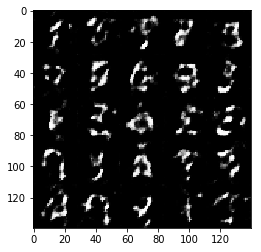

Epoch 1/2 - Batch 310/600:  Discriminator Loss: 1.2571 Generator Loss: 1.1790
Epoch 1/2 - Batch 320/600:  Discriminator Loss: 1.2434 Generator Loss: 1.5913
Epoch 1/2 - Batch 330/600:  Discriminator Loss: 1.0564 Generator Loss: 1.2157
Epoch 1/2 - Batch 340/600:  Discriminator Loss: 1.2575 Generator Loss: 0.7812
Epoch 1/2 - Batch 350/600:  Discriminator Loss: 0.9722 Generator Loss: 1.4882
Epoch 1/2 - Batch 360/600:  Discriminator Loss: 1.0981 Generator Loss: 1.6705
Epoch 1/2 - Batch 370/600:  Discriminator Loss: 1.0011 Generator Loss: 1.1872
Epoch 1/2 - Batch 380/600:  Discriminator Loss: 1.0854 Generator Loss: 1.4693
Epoch 1/2 - Batch 390/600:  Discriminator Loss: 1.1174 Generator Loss: 1.9884
Epoch 1/2 - Batch 400/600:  Discriminator Loss: 1.1274 Generator Loss: 1.4108


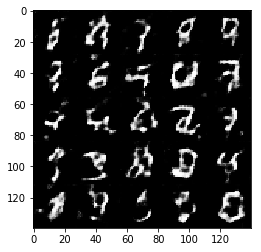

Epoch 1/2 - Batch 410/600:  Discriminator Loss: 1.0123 Generator Loss: 1.6117
Epoch 1/2 - Batch 420/600:  Discriminator Loss: 1.3212 Generator Loss: 2.3475
Epoch 1/2 - Batch 430/600:  Discriminator Loss: 1.1798 Generator Loss: 1.0611
Epoch 1/2 - Batch 440/600:  Discriminator Loss: 0.9805 Generator Loss: 1.7009
Epoch 1/2 - Batch 450/600:  Discriminator Loss: 1.1410 Generator Loss: 1.3737
Epoch 1/2 - Batch 460/600:  Discriminator Loss: 1.1197 Generator Loss: 1.2088
Epoch 1/2 - Batch 470/600:  Discriminator Loss: 1.0553 Generator Loss: 1.3073
Epoch 1/2 - Batch 480/600:  Discriminator Loss: 0.9575 Generator Loss: 1.6891
Epoch 1/2 - Batch 490/600:  Discriminator Loss: 1.1373 Generator Loss: 1.1031
Epoch 1/2 - Batch 500/600:  Discriminator Loss: 1.0072 Generator Loss: 2.0456


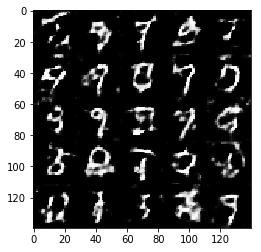

Epoch 1/2 - Batch 510/600:  Discriminator Loss: 1.0273 Generator Loss: 1.4343
Epoch 1/2 - Batch 520/600:  Discriminator Loss: 1.1054 Generator Loss: 2.0503
Epoch 1/2 - Batch 530/600:  Discriminator Loss: 1.0953 Generator Loss: 1.2607
Epoch 1/2 - Batch 540/600:  Discriminator Loss: 1.0288 Generator Loss: 1.2700
Epoch 1/2 - Batch 550/600:  Discriminator Loss: 1.0887 Generator Loss: 1.4357
Epoch 1/2 - Batch 560/600:  Discriminator Loss: 1.1474 Generator Loss: 1.0553
Epoch 1/2 - Batch 570/600:  Discriminator Loss: 1.0917 Generator Loss: 1.2721
Epoch 1/2 - Batch 580/600:  Discriminator Loss: 0.9357 Generator Loss: 1.6115
Epoch 1/2 - Batch 590/600:  Discriminator Loss: 1.0163 Generator Loss: 1.2520
Epoch 1/2 - Batch 600/600:  Discriminator Loss: 1.0687 Generator Loss: 1.4280


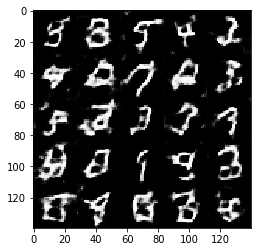

Epoch 2/2 - Batch 10/600:  Discriminator Loss: 1.1752 Generator Loss: 1.5604
Epoch 2/2 - Batch 20/600:  Discriminator Loss: 1.1845 Generator Loss: 1.8061
Epoch 2/2 - Batch 30/600:  Discriminator Loss: 1.0269 Generator Loss: 1.6221
Epoch 2/2 - Batch 40/600:  Discriminator Loss: 1.1166 Generator Loss: 1.7861
Epoch 2/2 - Batch 50/600:  Discriminator Loss: 1.0987 Generator Loss: 1.2900
Epoch 2/2 - Batch 60/600:  Discriminator Loss: 0.9459 Generator Loss: 1.2201
Epoch 2/2 - Batch 70/600:  Discriminator Loss: 1.1172 Generator Loss: 0.8983
Epoch 2/2 - Batch 80/600:  Discriminator Loss: 0.9998 Generator Loss: 1.8071
Epoch 2/2 - Batch 90/600:  Discriminator Loss: 0.9331 Generator Loss: 1.7111
Epoch 2/2 - Batch 100/600:  Discriminator Loss: 1.0243 Generator Loss: 1.1511


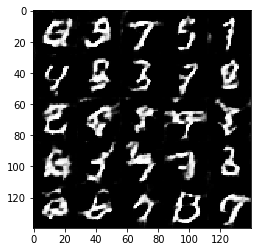

Epoch 2/2 - Batch 110/600:  Discriminator Loss: 1.1364 Generator Loss: 0.9805
Epoch 2/2 - Batch 120/600:  Discriminator Loss: 1.0497 Generator Loss: 1.2513
Epoch 2/2 - Batch 130/600:  Discriminator Loss: 1.2391 Generator Loss: 2.1934
Epoch 2/2 - Batch 140/600:  Discriminator Loss: 1.0215 Generator Loss: 1.5834
Epoch 2/2 - Batch 150/600:  Discriminator Loss: 1.0776 Generator Loss: 2.0863
Epoch 2/2 - Batch 160/600:  Discriminator Loss: 1.0493 Generator Loss: 1.3812
Epoch 2/2 - Batch 170/600:  Discriminator Loss: 1.0870 Generator Loss: 1.1291
Epoch 2/2 - Batch 180/600:  Discriminator Loss: 1.0344 Generator Loss: 1.6015
Epoch 2/2 - Batch 190/600:  Discriminator Loss: 1.0929 Generator Loss: 1.8081
Epoch 2/2 - Batch 200/600:  Discriminator Loss: 1.1715 Generator Loss: 0.8517


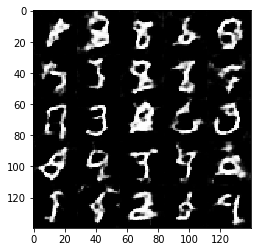

Epoch 2/2 - Batch 210/600:  Discriminator Loss: 1.1193 Generator Loss: 0.9688
Epoch 2/2 - Batch 220/600:  Discriminator Loss: 1.1979 Generator Loss: 2.0290
Epoch 2/2 - Batch 230/600:  Discriminator Loss: 0.9684 Generator Loss: 1.1373
Epoch 2/2 - Batch 240/600:  Discriminator Loss: 0.9485 Generator Loss: 1.7963
Epoch 2/2 - Batch 250/600:  Discriminator Loss: 1.0951 Generator Loss: 1.3070
Epoch 2/2 - Batch 260/600:  Discriminator Loss: 1.1854 Generator Loss: 0.7650
Epoch 2/2 - Batch 270/600:  Discriminator Loss: 1.0206 Generator Loss: 1.2561
Epoch 2/2 - Batch 280/600:  Discriminator Loss: 1.0569 Generator Loss: 1.0326
Epoch 2/2 - Batch 290/600:  Discriminator Loss: 1.0459 Generator Loss: 1.5788
Epoch 2/2 - Batch 300/600:  Discriminator Loss: 1.4566 Generator Loss: 2.4640


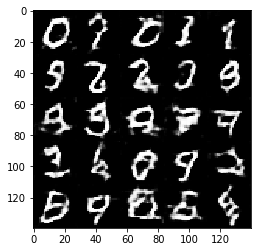

Epoch 2/2 - Batch 310/600:  Discriminator Loss: 1.0502 Generator Loss: 1.0534
Epoch 2/2 - Batch 320/600:  Discriminator Loss: 1.1475 Generator Loss: 1.9326
Epoch 2/2 - Batch 330/600:  Discriminator Loss: 1.0205 Generator Loss: 1.5037
Epoch 2/2 - Batch 340/600:  Discriminator Loss: 1.1138 Generator Loss: 1.3428
Epoch 2/2 - Batch 350/600:  Discriminator Loss: 1.0399 Generator Loss: 1.8526
Epoch 2/2 - Batch 360/600:  Discriminator Loss: 1.0678 Generator Loss: 1.6707
Epoch 2/2 - Batch 370/600:  Discriminator Loss: 1.0116 Generator Loss: 1.3280
Epoch 2/2 - Batch 380/600:  Discriminator Loss: 1.0969 Generator Loss: 1.2469
Epoch 2/2 - Batch 390/600:  Discriminator Loss: 1.1486 Generator Loss: 2.0530
Epoch 2/2 - Batch 400/600:  Discriminator Loss: 1.0699 Generator Loss: 1.2468


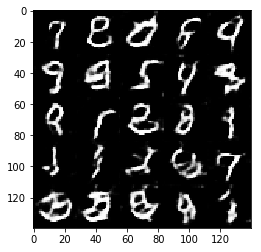

Epoch 2/2 - Batch 410/600:  Discriminator Loss: 1.0282 Generator Loss: 1.4709
Epoch 2/2 - Batch 420/600:  Discriminator Loss: 1.0127 Generator Loss: 1.3535
Epoch 2/2 - Batch 430/600:  Discriminator Loss: 1.0968 Generator Loss: 1.1715
Epoch 2/2 - Batch 440/600:  Discriminator Loss: 1.1389 Generator Loss: 1.7133
Epoch 2/2 - Batch 450/600:  Discriminator Loss: 1.1011 Generator Loss: 1.1271
Epoch 2/2 - Batch 460/600:  Discriminator Loss: 1.0493 Generator Loss: 1.5322
Epoch 2/2 - Batch 470/600:  Discriminator Loss: 0.9100 Generator Loss: 1.5103
Epoch 2/2 - Batch 480/600:  Discriminator Loss: 0.9396 Generator Loss: 1.3870
Epoch 2/2 - Batch 490/600:  Discriminator Loss: 1.1966 Generator Loss: 1.0070
Epoch 2/2 - Batch 500/600:  Discriminator Loss: 0.9449 Generator Loss: 1.8181


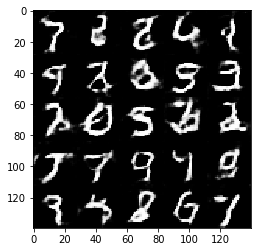

Epoch 2/2 - Batch 510/600:  Discriminator Loss: 1.1712 Generator Loss: 1.2494
Epoch 2/2 - Batch 520/600:  Discriminator Loss: 0.9925 Generator Loss: 1.2512
Epoch 2/2 - Batch 530/600:  Discriminator Loss: 1.1474 Generator Loss: 0.9895
Epoch 2/2 - Batch 540/600:  Discriminator Loss: 1.1443 Generator Loss: 1.3878
Epoch 2/2 - Batch 550/600:  Discriminator Loss: 1.0219 Generator Loss: 1.5265
Epoch 2/2 - Batch 560/600:  Discriminator Loss: 1.1097 Generator Loss: 1.2338
Epoch 2/2 - Batch 570/600:  Discriminator Loss: 1.1124 Generator Loss: 1.1162
Epoch 2/2 - Batch 580/600:  Discriminator Loss: 1.0639 Generator Loss: 2.0548
Epoch 2/2 - Batch 590/600:  Discriminator Loss: 1.0768 Generator Loss: 1.2969
Epoch 2/2 - Batch 600/600:  Discriminator Loss: 1.1319 Generator Loss: 1.6694


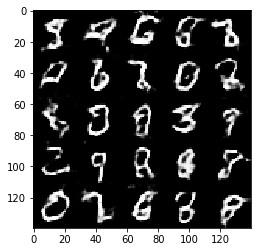

In [12]:
batch_size = 100
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 - Batch 10/3165:  Discriminator Loss: 0.6812 Generator Loss: 2.2169
Epoch 1/1 - Batch 20/3165:  Discriminator Loss: 0.4915 Generator Loss: 2.9054
Epoch 1/1 - Batch 30/3165:  Discriminator Loss: 2.5699 Generator Loss: 6.9854
Epoch 1/1 - Batch 40/3165:  Discriminator Loss: 0.6370 Generator Loss: 2.5630
Epoch 1/1 - Batch 50/3165:  Discriminator Loss: 0.5306 Generator Loss: 3.2369
Epoch 1/1 - Batch 60/3165:  Discriminator Loss: 0.4330 Generator Loss: 4.1479
Epoch 1/1 - Batch 70/3165:  Discriminator Loss: 0.4768 Generator Loss: 3.5207
Epoch 1/1 - Batch 80/3165:  Discriminator Loss: 0.4084 Generator Loss: 4.2599
Epoch 1/1 - Batch 90/3165:  Discriminator Loss: 0.4341 Generator Loss: 3.9692
Epoch 1/1 - Batch 100/3165:  Discriminator Loss: 1.0626 Generator Loss: 10.5434


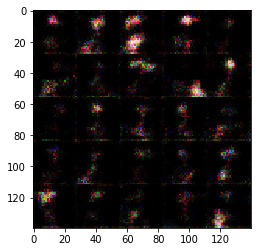

Epoch 1/1 - Batch 110/3165:  Discriminator Loss: 0.4310 Generator Loss: 3.9856
Epoch 1/1 - Batch 120/3165:  Discriminator Loss: 0.3811 Generator Loss: 6.0708
Epoch 1/1 - Batch 130/3165:  Discriminator Loss: 0.3491 Generator Loss: 5.9663
Epoch 1/1 - Batch 140/3165:  Discriminator Loss: 0.4528 Generator Loss: 2.6100
Epoch 1/1 - Batch 150/3165:  Discriminator Loss: 0.3877 Generator Loss: 5.4156
Epoch 1/1 - Batch 160/3165:  Discriminator Loss: 0.3776 Generator Loss: 4.5097
Epoch 1/1 - Batch 170/3165:  Discriminator Loss: 0.6473 Generator Loss: 2.9265
Epoch 1/1 - Batch 180/3165:  Discriminator Loss: 0.4801 Generator Loss: 2.9248
Epoch 1/1 - Batch 190/3165:  Discriminator Loss: 0.3728 Generator Loss: 4.9735
Epoch 1/1 - Batch 200/3165:  Discriminator Loss: 0.3658 Generator Loss: 4.9117


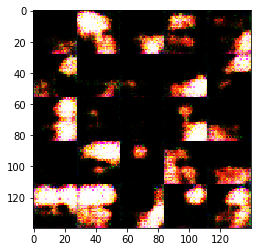

Epoch 1/1 - Batch 210/3165:  Discriminator Loss: 0.3518 Generator Loss: 5.3577
Epoch 1/1 - Batch 220/3165:  Discriminator Loss: 0.3567 Generator Loss: 4.5635
Epoch 1/1 - Batch 230/3165:  Discriminator Loss: 1.6309 Generator Loss: 0.6238
Epoch 1/1 - Batch 240/3165:  Discriminator Loss: 0.6101 Generator Loss: 1.7388
Epoch 1/1 - Batch 250/3165:  Discriminator Loss: 0.4535 Generator Loss: 3.3509
Epoch 1/1 - Batch 260/3165:  Discriminator Loss: 0.4514 Generator Loss: 5.2465
Epoch 1/1 - Batch 270/3165:  Discriminator Loss: 0.4213 Generator Loss: 3.2938
Epoch 1/1 - Batch 280/3165:  Discriminator Loss: 0.5089 Generator Loss: 3.4936
Epoch 1/1 - Batch 290/3165:  Discriminator Loss: 0.6506 Generator Loss: 1.9753
Epoch 1/1 - Batch 300/3165:  Discriminator Loss: 0.4773 Generator Loss: 2.9385


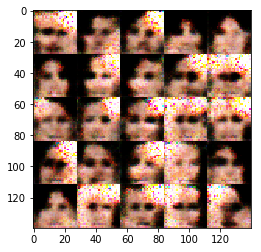

Epoch 1/1 - Batch 310/3165:  Discriminator Loss: 1.0223 Generator Loss: 1.2946
Epoch 1/1 - Batch 320/3165:  Discriminator Loss: 0.8294 Generator Loss: 1.6984
Epoch 1/1 - Batch 330/3165:  Discriminator Loss: 0.5374 Generator Loss: 3.5204
Epoch 1/1 - Batch 340/3165:  Discriminator Loss: 0.9562 Generator Loss: 3.3012
Epoch 1/1 - Batch 350/3165:  Discriminator Loss: 0.5319 Generator Loss: 2.8779
Epoch 1/1 - Batch 360/3165:  Discriminator Loss: 0.5669 Generator Loss: 2.9478
Epoch 1/1 - Batch 370/3165:  Discriminator Loss: 0.7013 Generator Loss: 3.1176
Epoch 1/1 - Batch 380/3165:  Discriminator Loss: 0.7857 Generator Loss: 2.8367
Epoch 1/1 - Batch 390/3165:  Discriminator Loss: 0.7220 Generator Loss: 2.5848
Epoch 1/1 - Batch 400/3165:  Discriminator Loss: 0.8046 Generator Loss: 2.0278


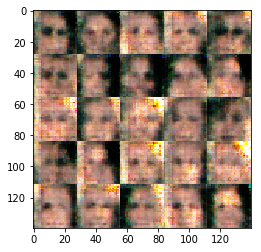

Epoch 1/1 - Batch 410/3165:  Discriminator Loss: 0.7676 Generator Loss: 2.0827
Epoch 1/1 - Batch 420/3165:  Discriminator Loss: 0.8667 Generator Loss: 1.7588
Epoch 1/1 - Batch 430/3165:  Discriminator Loss: 0.9086 Generator Loss: 2.4486
Epoch 1/1 - Batch 440/3165:  Discriminator Loss: 1.4291 Generator Loss: 0.7250
Epoch 1/1 - Batch 450/3165:  Discriminator Loss: 1.3871 Generator Loss: 0.7881
Epoch 1/1 - Batch 460/3165:  Discriminator Loss: 1.0354 Generator Loss: 1.4099
Epoch 1/1 - Batch 470/3165:  Discriminator Loss: 0.9850 Generator Loss: 1.1339
Epoch 1/1 - Batch 480/3165:  Discriminator Loss: 0.8962 Generator Loss: 1.7427
Epoch 1/1 - Batch 490/3165:  Discriminator Loss: 1.0023 Generator Loss: 1.6441
Epoch 1/1 - Batch 500/3165:  Discriminator Loss: 0.9223 Generator Loss: 1.7789


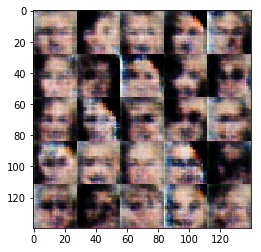

Epoch 1/1 - Batch 510/3165:  Discriminator Loss: 0.9710 Generator Loss: 2.0522
Epoch 1/1 - Batch 520/3165:  Discriminator Loss: 1.2175 Generator Loss: 3.0457
Epoch 1/1 - Batch 530/3165:  Discriminator Loss: 0.8691 Generator Loss: 1.8276
Epoch 1/1 - Batch 540/3165:  Discriminator Loss: 1.0620 Generator Loss: 1.2653
Epoch 1/1 - Batch 550/3165:  Discriminator Loss: 1.0791 Generator Loss: 2.2263
Epoch 1/1 - Batch 560/3165:  Discriminator Loss: 0.9537 Generator Loss: 1.8829
Epoch 1/1 - Batch 570/3165:  Discriminator Loss: 1.0277 Generator Loss: 1.4566
Epoch 1/1 - Batch 580/3165:  Discriminator Loss: 0.9687 Generator Loss: 1.2463
Epoch 1/1 - Batch 590/3165:  Discriminator Loss: 0.8184 Generator Loss: 2.4474
Epoch 1/1 - Batch 600/3165:  Discriminator Loss: 0.8490 Generator Loss: 1.8052


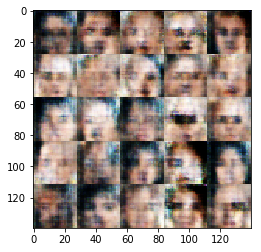

Epoch 1/1 - Batch 610/3165:  Discriminator Loss: 1.0072 Generator Loss: 2.0115
Epoch 1/1 - Batch 620/3165:  Discriminator Loss: 1.0104 Generator Loss: 1.8871
Epoch 1/1 - Batch 630/3165:  Discriminator Loss: 1.4399 Generator Loss: 4.1465
Epoch 1/1 - Batch 640/3165:  Discriminator Loss: 0.8065 Generator Loss: 1.9876
Epoch 1/1 - Batch 650/3165:  Discriminator Loss: 1.0545 Generator Loss: 1.6194
Epoch 1/1 - Batch 660/3165:  Discriminator Loss: 0.9246 Generator Loss: 1.6160
Epoch 1/1 - Batch 670/3165:  Discriminator Loss: 0.8836 Generator Loss: 1.8307
Epoch 1/1 - Batch 680/3165:  Discriminator Loss: 0.8067 Generator Loss: 2.3277
Epoch 1/1 - Batch 690/3165:  Discriminator Loss: 0.9204 Generator Loss: 1.9800
Epoch 1/1 - Batch 700/3165:  Discriminator Loss: 0.9449 Generator Loss: 2.7474


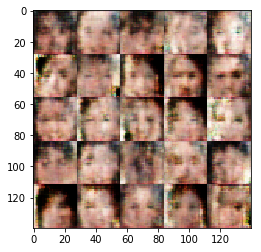

Epoch 1/1 - Batch 710/3165:  Discriminator Loss: 0.8365 Generator Loss: 1.7579
Epoch 1/1 - Batch 720/3165:  Discriminator Loss: 0.8773 Generator Loss: 1.9691
Epoch 1/1 - Batch 730/3165:  Discriminator Loss: 0.9770 Generator Loss: 1.3197
Epoch 1/1 - Batch 740/3165:  Discriminator Loss: 0.8501 Generator Loss: 2.3668
Epoch 1/1 - Batch 750/3165:  Discriminator Loss: 0.8790 Generator Loss: 1.5996
Epoch 1/1 - Batch 760/3165:  Discriminator Loss: 1.1351 Generator Loss: 1.1071
Epoch 1/1 - Batch 770/3165:  Discriminator Loss: 1.2067 Generator Loss: 1.0659
Epoch 1/1 - Batch 780/3165:  Discriminator Loss: 0.8164 Generator Loss: 1.8529
Epoch 1/1 - Batch 790/3165:  Discriminator Loss: 0.8175 Generator Loss: 1.6704
Epoch 1/1 - Batch 800/3165:  Discriminator Loss: 0.8090 Generator Loss: 2.3309


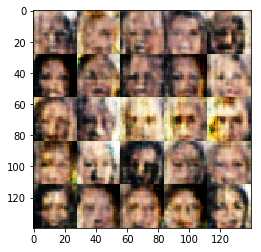

Epoch 1/1 - Batch 810/3165:  Discriminator Loss: 1.0956 Generator Loss: 1.0843
Epoch 1/1 - Batch 820/3165:  Discriminator Loss: 0.8633 Generator Loss: 2.0187
Epoch 1/1 - Batch 830/3165:  Discriminator Loss: 1.1119 Generator Loss: 1.1190
Epoch 1/1 - Batch 840/3165:  Discriminator Loss: 0.8544 Generator Loss: 1.6902
Epoch 1/1 - Batch 850/3165:  Discriminator Loss: 0.9660 Generator Loss: 1.7834
Epoch 1/1 - Batch 860/3165:  Discriminator Loss: 1.0252 Generator Loss: 2.8779
Epoch 1/1 - Batch 870/3165:  Discriminator Loss: 1.0827 Generator Loss: 1.9139
Epoch 1/1 - Batch 880/3165:  Discriminator Loss: 1.0438 Generator Loss: 1.0847
Epoch 1/1 - Batch 890/3165:  Discriminator Loss: 0.8390 Generator Loss: 1.9249
Epoch 1/1 - Batch 900/3165:  Discriminator Loss: 0.9140 Generator Loss: 1.7762


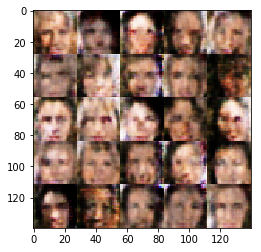

Epoch 1/1 - Batch 910/3165:  Discriminator Loss: 0.8825 Generator Loss: 1.5210
Epoch 1/1 - Batch 920/3165:  Discriminator Loss: 0.8612 Generator Loss: 1.6505
Epoch 1/1 - Batch 930/3165:  Discriminator Loss: 1.0111 Generator Loss: 2.3291
Epoch 1/1 - Batch 940/3165:  Discriminator Loss: 1.1866 Generator Loss: 1.6301
Epoch 1/1 - Batch 950/3165:  Discriminator Loss: 1.0392 Generator Loss: 1.2628
Epoch 1/1 - Batch 960/3165:  Discriminator Loss: 1.1470 Generator Loss: 2.0633
Epoch 1/1 - Batch 970/3165:  Discriminator Loss: 1.1465 Generator Loss: 1.2194
Epoch 1/1 - Batch 980/3165:  Discriminator Loss: 0.8625 Generator Loss: 1.9224
Epoch 1/1 - Batch 990/3165:  Discriminator Loss: 1.0276 Generator Loss: 1.6084
Epoch 1/1 - Batch 1000/3165:  Discriminator Loss: 1.0532 Generator Loss: 1.7494


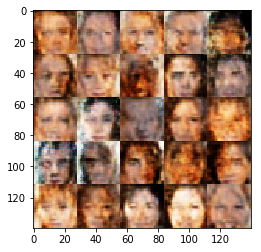

Epoch 1/1 - Batch 1010/3165:  Discriminator Loss: 1.0571 Generator Loss: 1.6410
Epoch 1/1 - Batch 1020/3165:  Discriminator Loss: 0.9568 Generator Loss: 1.6318
Epoch 1/1 - Batch 1030/3165:  Discriminator Loss: 0.9829 Generator Loss: 1.7338
Epoch 1/1 - Batch 1040/3165:  Discriminator Loss: 1.0094 Generator Loss: 1.9831
Epoch 1/1 - Batch 1050/3165:  Discriminator Loss: 1.1598 Generator Loss: 1.3909
Epoch 1/1 - Batch 1060/3165:  Discriminator Loss: 1.2061 Generator Loss: 1.0254
Epoch 1/1 - Batch 1070/3165:  Discriminator Loss: 1.0941 Generator Loss: 2.2723
Epoch 1/1 - Batch 1080/3165:  Discriminator Loss: 1.1074 Generator Loss: 1.4121
Epoch 1/1 - Batch 1090/3165:  Discriminator Loss: 1.0610 Generator Loss: 0.9181
Epoch 1/1 - Batch 1100/3165:  Discriminator Loss: 1.0938 Generator Loss: 1.6104


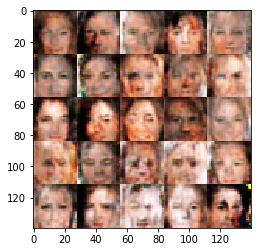

Epoch 1/1 - Batch 1110/3165:  Discriminator Loss: 0.9865 Generator Loss: 1.3386
Epoch 1/1 - Batch 1120/3165:  Discriminator Loss: 1.0714 Generator Loss: 1.7144
Epoch 1/1 - Batch 1130/3165:  Discriminator Loss: 1.1048 Generator Loss: 1.3567
Epoch 1/1 - Batch 1140/3165:  Discriminator Loss: 0.9633 Generator Loss: 1.7615
Epoch 1/1 - Batch 1150/3165:  Discriminator Loss: 1.2442 Generator Loss: 1.0802
Epoch 1/1 - Batch 1160/3165:  Discriminator Loss: 1.3019 Generator Loss: 1.2104
Epoch 1/1 - Batch 1170/3165:  Discriminator Loss: 1.1303 Generator Loss: 1.4748
Epoch 1/1 - Batch 1180/3165:  Discriminator Loss: 1.0560 Generator Loss: 1.1943
Epoch 1/1 - Batch 1190/3165:  Discriminator Loss: 1.4093 Generator Loss: 1.0250
Epoch 1/1 - Batch 1200/3165:  Discriminator Loss: 1.1229 Generator Loss: 1.7651


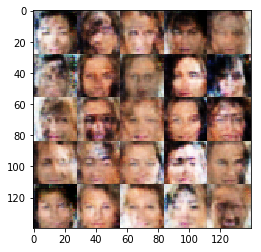

Epoch 1/1 - Batch 1210/3165:  Discriminator Loss: 1.0865 Generator Loss: 1.5657
Epoch 1/1 - Batch 1220/3165:  Discriminator Loss: 1.1056 Generator Loss: 0.9029
Epoch 1/1 - Batch 1230/3165:  Discriminator Loss: 0.9549 Generator Loss: 1.3637
Epoch 1/1 - Batch 1240/3165:  Discriminator Loss: 1.1196 Generator Loss: 1.4099
Epoch 1/1 - Batch 1250/3165:  Discriminator Loss: 1.0105 Generator Loss: 1.5150
Epoch 1/1 - Batch 1260/3165:  Discriminator Loss: 1.0954 Generator Loss: 1.0973
Epoch 1/1 - Batch 1270/3165:  Discriminator Loss: 1.0086 Generator Loss: 1.6332
Epoch 1/1 - Batch 1280/3165:  Discriminator Loss: 1.1010 Generator Loss: 1.7221
Epoch 1/1 - Batch 1290/3165:  Discriminator Loss: 1.1454 Generator Loss: 1.1970
Epoch 1/1 - Batch 1300/3165:  Discriminator Loss: 1.1521 Generator Loss: 1.1383


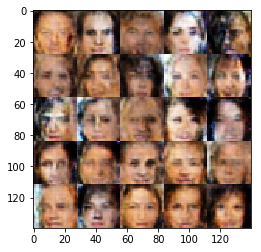

Epoch 1/1 - Batch 1310/3165:  Discriminator Loss: 1.1587 Generator Loss: 1.1821
Epoch 1/1 - Batch 1320/3165:  Discriminator Loss: 1.0778 Generator Loss: 1.5118
Epoch 1/1 - Batch 1330/3165:  Discriminator Loss: 1.1964 Generator Loss: 1.6428
Epoch 1/1 - Batch 1340/3165:  Discriminator Loss: 1.1881 Generator Loss: 1.3508
Epoch 1/1 - Batch 1350/3165:  Discriminator Loss: 1.2817 Generator Loss: 1.0310
Epoch 1/1 - Batch 1360/3165:  Discriminator Loss: 1.0498 Generator Loss: 1.2908
Epoch 1/1 - Batch 1370/3165:  Discriminator Loss: 1.0587 Generator Loss: 1.2078
Epoch 1/1 - Batch 1380/3165:  Discriminator Loss: 1.1176 Generator Loss: 0.9945
Epoch 1/1 - Batch 1390/3165:  Discriminator Loss: 1.0447 Generator Loss: 1.2276
Epoch 1/1 - Batch 1400/3165:  Discriminator Loss: 1.0251 Generator Loss: 1.4713


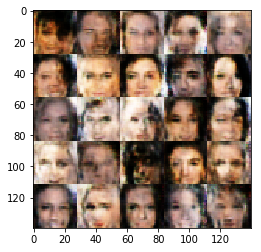

Epoch 1/1 - Batch 1410/3165:  Discriminator Loss: 1.2877 Generator Loss: 1.9855
Epoch 1/1 - Batch 1420/3165:  Discriminator Loss: 1.0635 Generator Loss: 1.2551
Epoch 1/1 - Batch 1430/3165:  Discriminator Loss: 1.2063 Generator Loss: 1.3275
Epoch 1/1 - Batch 1440/3165:  Discriminator Loss: 1.2723 Generator Loss: 0.9341
Epoch 1/1 - Batch 1450/3165:  Discriminator Loss: 1.0731 Generator Loss: 1.2892
Epoch 1/1 - Batch 1460/3165:  Discriminator Loss: 1.1457 Generator Loss: 1.3532
Epoch 1/1 - Batch 1470/3165:  Discriminator Loss: 1.0672 Generator Loss: 1.3902
Epoch 1/1 - Batch 1480/3165:  Discriminator Loss: 1.0466 Generator Loss: 1.5526
Epoch 1/1 - Batch 1490/3165:  Discriminator Loss: 1.1276 Generator Loss: 1.4269
Epoch 1/1 - Batch 1500/3165:  Discriminator Loss: 1.0695 Generator Loss: 1.1712


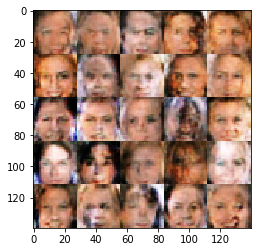

Epoch 1/1 - Batch 1510/3165:  Discriminator Loss: 1.0126 Generator Loss: 1.6235
Epoch 1/1 - Batch 1520/3165:  Discriminator Loss: 1.1774 Generator Loss: 1.3529
Epoch 1/1 - Batch 1530/3165:  Discriminator Loss: 1.2831 Generator Loss: 1.1185
Epoch 1/1 - Batch 1540/3165:  Discriminator Loss: 1.1649 Generator Loss: 1.1151
Epoch 1/1 - Batch 1550/3165:  Discriminator Loss: 1.0317 Generator Loss: 1.2041
Epoch 1/1 - Batch 1560/3165:  Discriminator Loss: 1.1700 Generator Loss: 1.1352
Epoch 1/1 - Batch 1570/3165:  Discriminator Loss: 1.1324 Generator Loss: 1.8995
Epoch 1/1 - Batch 1580/3165:  Discriminator Loss: 1.2214 Generator Loss: 2.0547
Epoch 1/1 - Batch 1590/3165:  Discriminator Loss: 1.3015 Generator Loss: 0.8695
Epoch 1/1 - Batch 1600/3165:  Discriminator Loss: 1.0361 Generator Loss: 1.3741


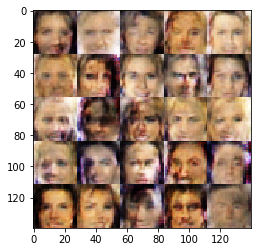

Epoch 1/1 - Batch 1610/3165:  Discriminator Loss: 1.0823 Generator Loss: 1.0020
Epoch 1/1 - Batch 1620/3165:  Discriminator Loss: 1.1257 Generator Loss: 2.1177
Epoch 1/1 - Batch 1630/3165:  Discriminator Loss: 1.1342 Generator Loss: 1.4799
Epoch 1/1 - Batch 1640/3165:  Discriminator Loss: 1.0314 Generator Loss: 1.7080
Epoch 1/1 - Batch 1650/3165:  Discriminator Loss: 1.2304 Generator Loss: 1.5925
Epoch 1/1 - Batch 1660/3165:  Discriminator Loss: 1.1174 Generator Loss: 0.9565
Epoch 1/1 - Batch 1670/3165:  Discriminator Loss: 1.1736 Generator Loss: 1.5208
Epoch 1/1 - Batch 1680/3165:  Discriminator Loss: 1.2779 Generator Loss: 2.1148
Epoch 1/1 - Batch 1690/3165:  Discriminator Loss: 1.4314 Generator Loss: 0.8050
Epoch 1/1 - Batch 1700/3165:  Discriminator Loss: 0.9775 Generator Loss: 1.4794


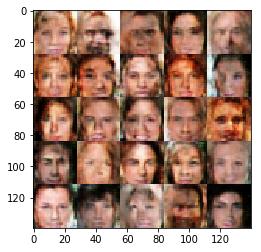

Epoch 1/1 - Batch 1710/3165:  Discriminator Loss: 1.2042 Generator Loss: 0.9340
Epoch 1/1 - Batch 1720/3165:  Discriminator Loss: 1.0935 Generator Loss: 1.3868
Epoch 1/1 - Batch 1730/3165:  Discriminator Loss: 1.2279 Generator Loss: 1.8811
Epoch 1/1 - Batch 1740/3165:  Discriminator Loss: 1.0754 Generator Loss: 1.4262
Epoch 1/1 - Batch 1750/3165:  Discriminator Loss: 1.1904 Generator Loss: 0.9132
Epoch 1/1 - Batch 1760/3165:  Discriminator Loss: 1.2177 Generator Loss: 0.9051
Epoch 1/1 - Batch 1770/3165:  Discriminator Loss: 1.1753 Generator Loss: 0.9433
Epoch 1/1 - Batch 1780/3165:  Discriminator Loss: 1.0713 Generator Loss: 1.3798
Epoch 1/1 - Batch 1790/3165:  Discriminator Loss: 1.0915 Generator Loss: 1.3585
Epoch 1/1 - Batch 1800/3165:  Discriminator Loss: 1.1123 Generator Loss: 0.8996


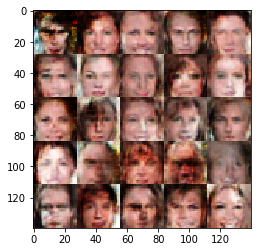

Epoch 1/1 - Batch 1810/3165:  Discriminator Loss: 1.2356 Generator Loss: 1.1733
Epoch 1/1 - Batch 1820/3165:  Discriminator Loss: 1.0582 Generator Loss: 1.4798
Epoch 1/1 - Batch 1830/3165:  Discriminator Loss: 1.1034 Generator Loss: 1.2217
Epoch 1/1 - Batch 1840/3165:  Discriminator Loss: 1.0242 Generator Loss: 1.2415
Epoch 1/1 - Batch 1850/3165:  Discriminator Loss: 1.1065 Generator Loss: 1.3712
Epoch 1/1 - Batch 1860/3165:  Discriminator Loss: 1.0210 Generator Loss: 1.6126
Epoch 1/1 - Batch 1870/3165:  Discriminator Loss: 1.2281 Generator Loss: 1.1895
Epoch 1/1 - Batch 1880/3165:  Discriminator Loss: 1.1897 Generator Loss: 1.0751
Epoch 1/1 - Batch 1890/3165:  Discriminator Loss: 1.2608 Generator Loss: 1.3974
Epoch 1/1 - Batch 1900/3165:  Discriminator Loss: 1.1676 Generator Loss: 1.1383


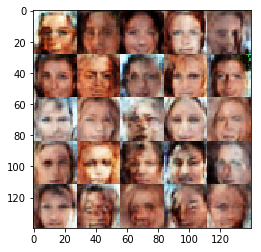

Epoch 1/1 - Batch 1910/3165:  Discriminator Loss: 1.2744 Generator Loss: 1.2000
Epoch 1/1 - Batch 1920/3165:  Discriminator Loss: 1.1079 Generator Loss: 1.2808
Epoch 1/1 - Batch 1930/3165:  Discriminator Loss: 1.1438 Generator Loss: 1.0668
Epoch 1/1 - Batch 1940/3165:  Discriminator Loss: 1.1102 Generator Loss: 1.0121
Epoch 1/1 - Batch 1950/3165:  Discriminator Loss: 1.1371 Generator Loss: 1.6602
Epoch 1/1 - Batch 1960/3165:  Discriminator Loss: 1.1016 Generator Loss: 1.1233
Epoch 1/1 - Batch 1970/3165:  Discriminator Loss: 1.2075 Generator Loss: 1.1959
Epoch 1/1 - Batch 1980/3165:  Discriminator Loss: 1.1436 Generator Loss: 1.7679
Epoch 1/1 - Batch 1990/3165:  Discriminator Loss: 1.2357 Generator Loss: 1.2455
Epoch 1/1 - Batch 2000/3165:  Discriminator Loss: 1.0869 Generator Loss: 1.3119


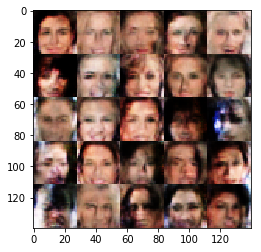

Epoch 1/1 - Batch 2010/3165:  Discriminator Loss: 1.1635 Generator Loss: 1.0710
Epoch 1/1 - Batch 2020/3165:  Discriminator Loss: 1.5457 Generator Loss: 0.4948
Epoch 1/1 - Batch 2030/3165:  Discriminator Loss: 1.2074 Generator Loss: 2.2304
Epoch 1/1 - Batch 2040/3165:  Discriminator Loss: 1.1441 Generator Loss: 1.4923
Epoch 1/1 - Batch 2050/3165:  Discriminator Loss: 1.3030 Generator Loss: 0.7874
Epoch 1/1 - Batch 2060/3165:  Discriminator Loss: 1.1666 Generator Loss: 1.4896
Epoch 1/1 - Batch 2070/3165:  Discriminator Loss: 1.3232 Generator Loss: 0.8316
Epoch 1/1 - Batch 2080/3165:  Discriminator Loss: 1.0748 Generator Loss: 0.9400
Epoch 1/1 - Batch 2090/3165:  Discriminator Loss: 1.1397 Generator Loss: 1.3681
Epoch 1/1 - Batch 2100/3165:  Discriminator Loss: 1.1318 Generator Loss: 1.1488


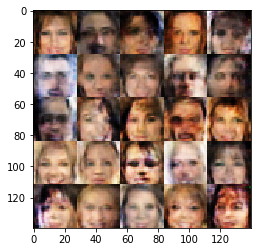

Epoch 1/1 - Batch 2110/3165:  Discriminator Loss: 1.1468 Generator Loss: 0.9519
Epoch 1/1 - Batch 2120/3165:  Discriminator Loss: 1.0885 Generator Loss: 1.3583
Epoch 1/1 - Batch 2130/3165:  Discriminator Loss: 1.1644 Generator Loss: 1.5120
Epoch 1/1 - Batch 2140/3165:  Discriminator Loss: 1.1335 Generator Loss: 1.4823
Epoch 1/1 - Batch 2150/3165:  Discriminator Loss: 1.1477 Generator Loss: 1.5067
Epoch 1/1 - Batch 2160/3165:  Discriminator Loss: 1.2816 Generator Loss: 0.7741
Epoch 1/1 - Batch 2170/3165:  Discriminator Loss: 1.0306 Generator Loss: 1.3723
Epoch 1/1 - Batch 2180/3165:  Discriminator Loss: 1.1762 Generator Loss: 1.3965
Epoch 1/1 - Batch 2190/3165:  Discriminator Loss: 1.2529 Generator Loss: 1.1566
Epoch 1/1 - Batch 2200/3165:  Discriminator Loss: 1.1820 Generator Loss: 1.6420


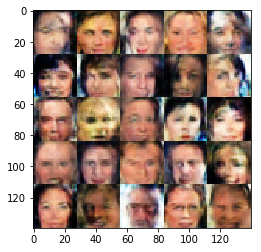

Epoch 1/1 - Batch 2210/3165:  Discriminator Loss: 1.1291 Generator Loss: 1.2457
Epoch 1/1 - Batch 2220/3165:  Discriminator Loss: 1.0335 Generator Loss: 1.2608
Epoch 1/1 - Batch 2230/3165:  Discriminator Loss: 1.1022 Generator Loss: 1.0495
Epoch 1/1 - Batch 2240/3165:  Discriminator Loss: 1.1788 Generator Loss: 1.3754
Epoch 1/1 - Batch 2250/3165:  Discriminator Loss: 1.1701 Generator Loss: 0.8137
Epoch 1/1 - Batch 2260/3165:  Discriminator Loss: 1.0218 Generator Loss: 1.3773
Epoch 1/1 - Batch 2270/3165:  Discriminator Loss: 1.0643 Generator Loss: 1.0288
Epoch 1/1 - Batch 2280/3165:  Discriminator Loss: 1.0718 Generator Loss: 1.0901
Epoch 1/1 - Batch 2290/3165:  Discriminator Loss: 1.1300 Generator Loss: 1.2366
Epoch 1/1 - Batch 2300/3165:  Discriminator Loss: 1.0975 Generator Loss: 1.2918


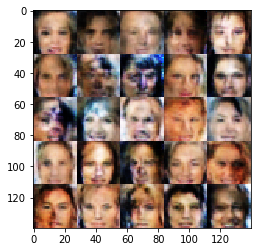

Epoch 1/1 - Batch 2310/3165:  Discriminator Loss: 1.1614 Generator Loss: 0.8031
Epoch 1/1 - Batch 2320/3165:  Discriminator Loss: 1.1612 Generator Loss: 1.5107
Epoch 1/1 - Batch 2330/3165:  Discriminator Loss: 1.3585 Generator Loss: 1.9697
Epoch 1/1 - Batch 2340/3165:  Discriminator Loss: 1.2679 Generator Loss: 0.9061
Epoch 1/1 - Batch 2350/3165:  Discriminator Loss: 1.1368 Generator Loss: 1.0308
Epoch 1/1 - Batch 2360/3165:  Discriminator Loss: 1.1220 Generator Loss: 1.3533
Epoch 1/1 - Batch 2370/3165:  Discriminator Loss: 1.1601 Generator Loss: 1.2098
Epoch 1/1 - Batch 2380/3165:  Discriminator Loss: 1.4943 Generator Loss: 0.6519
Epoch 1/1 - Batch 2390/3165:  Discriminator Loss: 1.0162 Generator Loss: 0.9369
Epoch 1/1 - Batch 2400/3165:  Discriminator Loss: 1.2352 Generator Loss: 1.3469


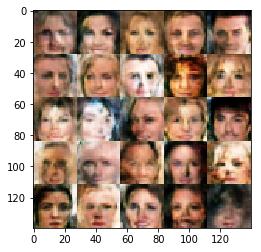

Epoch 1/1 - Batch 2410/3165:  Discriminator Loss: 1.1377 Generator Loss: 1.5468
Epoch 1/1 - Batch 2420/3165:  Discriminator Loss: 1.1958 Generator Loss: 1.4705
Epoch 1/1 - Batch 2430/3165:  Discriminator Loss: 1.2342 Generator Loss: 1.4654
Epoch 1/1 - Batch 2440/3165:  Discriminator Loss: 1.2460 Generator Loss: 1.1175
Epoch 1/1 - Batch 2450/3165:  Discriminator Loss: 1.0611 Generator Loss: 1.0759
Epoch 1/1 - Batch 2460/3165:  Discriminator Loss: 1.1272 Generator Loss: 1.4020
Epoch 1/1 - Batch 2470/3165:  Discriminator Loss: 1.1771 Generator Loss: 1.4782
Epoch 1/1 - Batch 2480/3165:  Discriminator Loss: 1.3468 Generator Loss: 1.0436
Epoch 1/1 - Batch 2490/3165:  Discriminator Loss: 1.0622 Generator Loss: 0.8616
Epoch 1/1 - Batch 2500/3165:  Discriminator Loss: 1.3307 Generator Loss: 1.6306


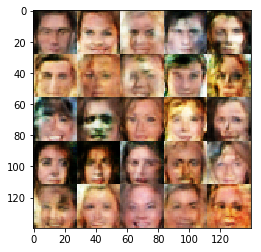

Epoch 1/1 - Batch 2510/3165:  Discriminator Loss: 1.1937 Generator Loss: 1.4860
Epoch 1/1 - Batch 2520/3165:  Discriminator Loss: 1.0460 Generator Loss: 1.1401
Epoch 1/1 - Batch 2530/3165:  Discriminator Loss: 1.0215 Generator Loss: 1.1206
Epoch 1/1 - Batch 2540/3165:  Discriminator Loss: 1.1097 Generator Loss: 1.5044
Epoch 1/1 - Batch 2550/3165:  Discriminator Loss: 1.1855 Generator Loss: 1.7160
Epoch 1/1 - Batch 2560/3165:  Discriminator Loss: 1.2570 Generator Loss: 1.7789
Epoch 1/1 - Batch 2570/3165:  Discriminator Loss: 1.0974 Generator Loss: 1.2969
Epoch 1/1 - Batch 2580/3165:  Discriminator Loss: 1.1033 Generator Loss: 1.4628
Epoch 1/1 - Batch 2590/3165:  Discriminator Loss: 1.1594 Generator Loss: 1.0577
Epoch 1/1 - Batch 2600/3165:  Discriminator Loss: 1.1020 Generator Loss: 1.1714


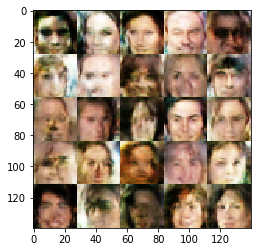

Epoch 1/1 - Batch 2610/3165:  Discriminator Loss: 0.9827 Generator Loss: 1.5592
Epoch 1/1 - Batch 2620/3165:  Discriminator Loss: 1.0908 Generator Loss: 1.3102
Epoch 1/1 - Batch 2630/3165:  Discriminator Loss: 1.1696 Generator Loss: 0.7928
Epoch 1/1 - Batch 2640/3165:  Discriminator Loss: 0.9926 Generator Loss: 1.3673
Epoch 1/1 - Batch 2650/3165:  Discriminator Loss: 1.3148 Generator Loss: 1.8562
Epoch 1/1 - Batch 2660/3165:  Discriminator Loss: 1.2061 Generator Loss: 1.9106
Epoch 1/1 - Batch 2670/3165:  Discriminator Loss: 1.1950 Generator Loss: 1.2169
Epoch 1/1 - Batch 2680/3165:  Discriminator Loss: 1.0936 Generator Loss: 1.1560
Epoch 1/1 - Batch 2690/3165:  Discriminator Loss: 1.2378 Generator Loss: 1.0828
Epoch 1/1 - Batch 2700/3165:  Discriminator Loss: 1.1542 Generator Loss: 0.9926


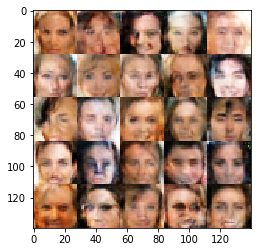

Epoch 1/1 - Batch 2710/3165:  Discriminator Loss: 1.0557 Generator Loss: 1.3174
Epoch 1/1 - Batch 2720/3165:  Discriminator Loss: 1.0521 Generator Loss: 1.2967
Epoch 1/1 - Batch 2730/3165:  Discriminator Loss: 1.0627 Generator Loss: 1.7816
Epoch 1/1 - Batch 2740/3165:  Discriminator Loss: 1.1390 Generator Loss: 1.1900
Epoch 1/1 - Batch 2750/3165:  Discriminator Loss: 1.1085 Generator Loss: 1.4236
Epoch 1/1 - Batch 2760/3165:  Discriminator Loss: 1.2170 Generator Loss: 0.7834
Epoch 1/1 - Batch 2770/3165:  Discriminator Loss: 1.2221 Generator Loss: 0.7756
Epoch 1/1 - Batch 2780/3165:  Discriminator Loss: 1.1732 Generator Loss: 1.5948
Epoch 1/1 - Batch 2790/3165:  Discriminator Loss: 1.1519 Generator Loss: 1.2160
Epoch 1/1 - Batch 2800/3165:  Discriminator Loss: 1.0532 Generator Loss: 1.6253


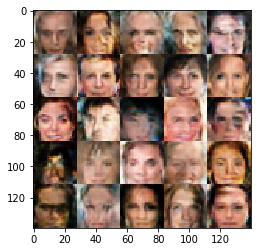

Epoch 1/1 - Batch 2810/3165:  Discriminator Loss: 1.2242 Generator Loss: 0.9841
Epoch 1/1 - Batch 2820/3165:  Discriminator Loss: 1.0363 Generator Loss: 1.4796
Epoch 1/1 - Batch 2830/3165:  Discriminator Loss: 1.2036 Generator Loss: 1.2394
Epoch 1/1 - Batch 2840/3165:  Discriminator Loss: 1.2212 Generator Loss: 1.1226
Epoch 1/1 - Batch 2850/3165:  Discriminator Loss: 1.2798 Generator Loss: 0.8324
Epoch 1/1 - Batch 2860/3165:  Discriminator Loss: 1.1589 Generator Loss: 0.9894
Epoch 1/1 - Batch 2870/3165:  Discriminator Loss: 1.2378 Generator Loss: 0.7328
Epoch 1/1 - Batch 2880/3165:  Discriminator Loss: 1.1729 Generator Loss: 1.1997
Epoch 1/1 - Batch 2890/3165:  Discriminator Loss: 1.1848 Generator Loss: 1.2144
Epoch 1/1 - Batch 2900/3165:  Discriminator Loss: 1.1485 Generator Loss: 1.5424


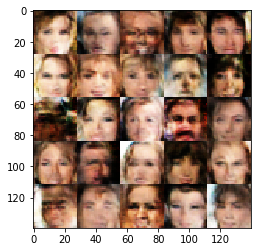

Epoch 1/1 - Batch 2910/3165:  Discriminator Loss: 1.2069 Generator Loss: 0.9073
Epoch 1/1 - Batch 2920/3165:  Discriminator Loss: 1.2105 Generator Loss: 0.9135
Epoch 1/1 - Batch 2930/3165:  Discriminator Loss: 1.0522 Generator Loss: 1.1561
Epoch 1/1 - Batch 2940/3165:  Discriminator Loss: 1.1478 Generator Loss: 1.3983
Epoch 1/1 - Batch 2950/3165:  Discriminator Loss: 1.2506 Generator Loss: 1.6297
Epoch 1/1 - Batch 2960/3165:  Discriminator Loss: 1.2661 Generator Loss: 0.8332
Epoch 1/1 - Batch 2970/3165:  Discriminator Loss: 1.3434 Generator Loss: 1.9399
Epoch 1/1 - Batch 2980/3165:  Discriminator Loss: 1.1478 Generator Loss: 1.7492
Epoch 1/1 - Batch 2990/3165:  Discriminator Loss: 1.0714 Generator Loss: 1.4398
Epoch 1/1 - Batch 3000/3165:  Discriminator Loss: 1.2675 Generator Loss: 0.9904


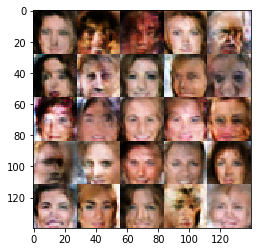

Epoch 1/1 - Batch 3010/3165:  Discriminator Loss: 1.1188 Generator Loss: 1.6155
Epoch 1/1 - Batch 3020/3165:  Discriminator Loss: 1.0322 Generator Loss: 1.1315
Epoch 1/1 - Batch 3030/3165:  Discriminator Loss: 1.2013 Generator Loss: 0.9369
Epoch 1/1 - Batch 3040/3165:  Discriminator Loss: 1.2984 Generator Loss: 2.0614
Epoch 1/1 - Batch 3050/3165:  Discriminator Loss: 1.1529 Generator Loss: 1.2643
Epoch 1/1 - Batch 3060/3165:  Discriminator Loss: 1.0914 Generator Loss: 1.4431
Epoch 1/1 - Batch 3070/3165:  Discriminator Loss: 1.1472 Generator Loss: 1.3160
Epoch 1/1 - Batch 3080/3165:  Discriminator Loss: 1.0949 Generator Loss: 1.3899
Epoch 1/1 - Batch 3090/3165:  Discriminator Loss: 1.1589 Generator Loss: 0.9423
Epoch 1/1 - Batch 3100/3165:  Discriminator Loss: 1.0754 Generator Loss: 1.3358


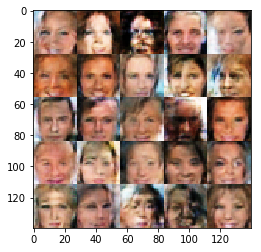

Epoch 1/1 - Batch 3110/3165:  Discriminator Loss: 1.0989 Generator Loss: 0.9455
Epoch 1/1 - Batch 3120/3165:  Discriminator Loss: 1.2258 Generator Loss: 1.0065
Epoch 1/1 - Batch 3130/3165:  Discriminator Loss: 1.0734 Generator Loss: 0.9306
Epoch 1/1 - Batch 3140/3165:  Discriminator Loss: 1.2360 Generator Loss: 0.8017
Epoch 1/1 - Batch 3150/3165:  Discriminator Loss: 1.1167 Generator Loss: 1.2622
Epoch 1/1 - Batch 3160/3165:  Discriminator Loss: 1.2057 Generator Loss: 0.9821


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.